In [1]:
import os
import glob
import sys
sys.path.append('/Users/aghavamp/Desktop/Projects')
sys.path.append('/Users/aghavamp/Desktop/Projects/bimanual_wrist')
sys.path.append('/Users/aghavamp/Desktop/Projects/Functional_Fusion')
import getpass
import importlib
from tqdm import tqdm
from pathlib import Path

import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import scipy.io as sio
import numpy as np
import pandas as pd

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')


# Vis 12x12 subject G matrices

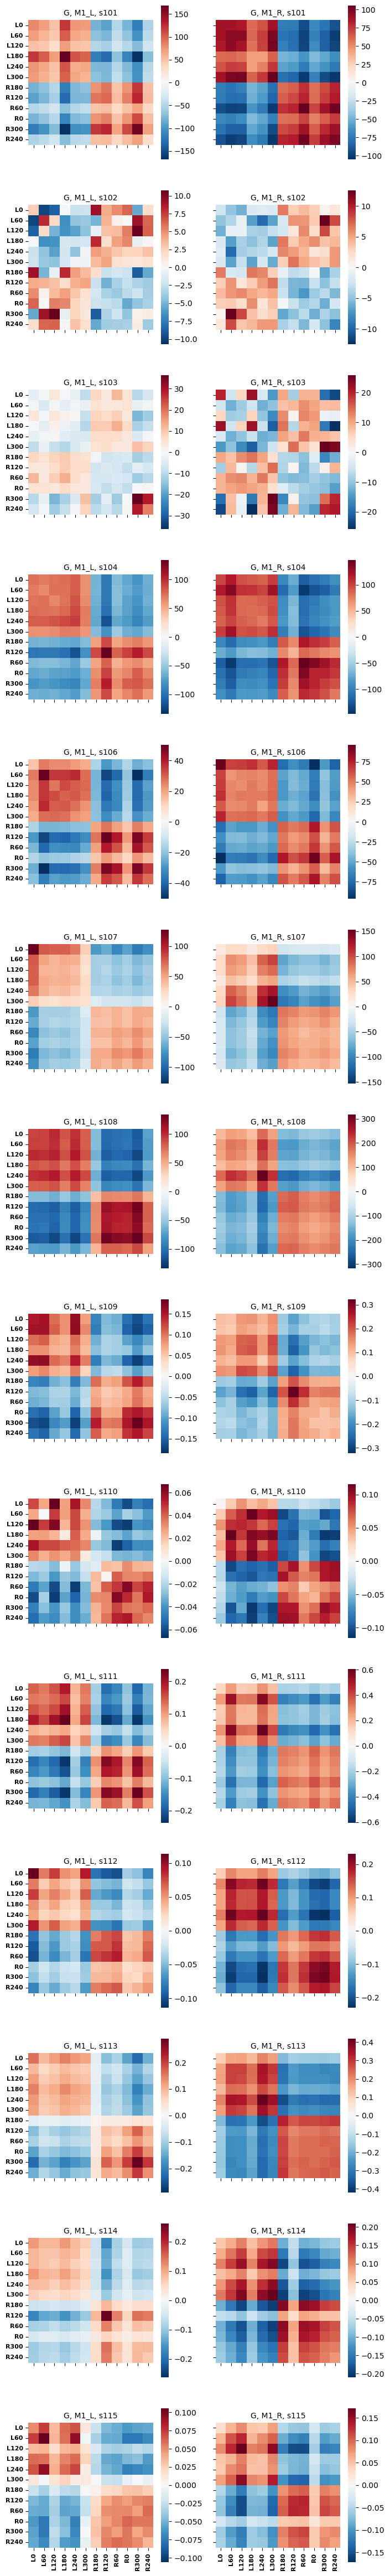

In [9]:
ana = pd.read_feather(os.path.join(analysisDir,'G_uni.feather'))

rdm_cols = ['lhand:0','lhand:60','lhand:120','lhand:180','lhand:240','lhand:300',
            'rhand:180','rhand:120','rhand:60','rhand:0','rhand:300','rhand:240'] 
labels = ['L0','L60','L120','L180','L240','L300',
          'R180','R120','R60','R0','R300','R240']
region_names = ['M1']

sn_list = ana.sn.unique()
sn_list = sn_list.tolist()
# sn_list = [101, 102, 103, 109, 110, 111, 112, 113, 114, 115]
hem = ana.hem.unique()
regions = ana.region.unique()

G_subj = []

cmap = matplotlib.cm.RdBu.reversed()
n_cond = len(rdm_cols)
fig, axes = plt.subplots(nrows=len(sn_list), ncols=2, figsize=(8,60), sharex=True, sharey=True)
for sn in sn_list:
    for i, h in enumerate(hem):
        ax = axes[sn_list.index(sn), i]
        row = ana[(ana.sn==sn) & (ana.hem==h) & (ana.region==region_names[0])]
        G_hat = utils.please.retrieve_matrix(row, prefix='G', colnames=rdm_cols)
        v_max = np.max(G_hat)
        v_min = np.min(G_hat)
        v_max = max(abs(v_max), abs(v_min))
        sns.heatmap(G_hat, cmap=cmap, square=True, cbar_kws={'label': ''}, ax=ax, vmin=-v_max, vmax=v_max, cbar=True)
        ax.set_title(f'G, {region_names[0]}_{h}, s{sn}', fontsize=10)

        # Set labels manually with more formatting options
        ax.set_xticks(np.arange(0,n_cond)+0.5)
        ax.set_xticklabels(labels, rotation=90, fontsize=8, fontweight='bold')
        ax.set_yticks(np.arange(0,n_cond)+0.5)
        ax.set_yticklabels(labels, rotation=0, fontsize=8, fontweight='bold')
        
# plt.tight_layout()
# plt.savefig(f'../figures/G_uni/s{sn}_G_uni.pdf', bbox_inches="tight")
plt.show()



# Modeling the unimanual 6x6 cov

make pcm dataset

In [18]:
roi = 'M1_L'
condition = 'rhand'

sn_bad = []

loaded = np.load(os.path.join(analysisDir, f'pwbeta_{roi}.npz'), allow_pickle=True)
subject = loaded['subject']
indices = [i for i, s in enumerate(subject) if s not in sn_bad]
subject = loaded['subject'][indices]
cond_name_tmp = loaded['cond_intrinsic_vec'][indices]
cond_vec_tmp = loaded['cond_num_vec'][indices]
data_tmp = loaded['data'][indices]
part_tmp = loaded['part_vec'][indices]

data = []
cond_name = []
cond_vec = []
part_vec = []
for i in range(len(subject)):
    # select only the condition of interest
    idx = [j for j, c in enumerate(cond_name_tmp[i]) if condition in c]
    data.append(data_tmp[i][idx, :])
    cond_name.append(cond_name_tmp[i][idx])
    cond_vec.append(cond_vec_tmp[i][idx])
    part_vec.append(part_tmp[i][idx])

Y = list()
for i in range(len(data)):
    obs_des = {'cond_vec': cond_vec[i],
               'part_vec': part_vec[i]}
    Y.append(pcm.dataset.Dataset(data[i],obs_descriptors = obs_des))

print(cond_name[0])
print(cond_vec[0])
print(part_vec[0])



['rhand:ext' 'rhand:flxup' 'rhand:flx' 'rhand:flxdn' 'rhand:extdn'
 'rhand:extup' 'rhand:ext' 'rhand:flxup' 'rhand:flx' 'rhand:flxdn'
 'rhand:extdn' 'rhand:extup' 'rhand:ext' 'rhand:flxup' 'rhand:flx'
 'rhand:flxdn' 'rhand:extdn' 'rhand:extup' 'rhand:ext' 'rhand:flxup'
 'rhand:flx' 'rhand:flxdn' 'rhand:extdn' 'rhand:extup' 'rhand:ext'
 'rhand:flxup' 'rhand:flx' 'rhand:flxdn' 'rhand:extdn' 'rhand:extup'
 'rhand:ext' 'rhand:flxup' 'rhand:flx' 'rhand:flxdn' 'rhand:extdn'
 'rhand:extup' 'rhand:ext' 'rhand:flxup' 'rhand:flx' 'rhand:flxdn'
 'rhand:extdn' 'rhand:extup' 'rhand:ext' 'rhand:flxup' 'rhand:flx'
 'rhand:flxdn' 'rhand:extdn' 'rhand:extup' 'rhand:ext' 'rhand:flxup'
 'rhand:flx' 'rhand:flxdn' 'rhand:extdn' 'rhand:extup' 'rhand:ext'
 'rhand:flxup' 'rhand:flx' 'rhand:flxdn' 'rhand:extdn' 'rhand:extup']
[ 9  7  6 11 10  8  9  7  6 11 10  8  9  7  6 11 10  8  9  7  6 11 10  8
  9  7  6 11 10  8  9  7  6 11 10  8  9  7  6 11 10  8  9  7  6 11 10  8
  9  7  6 11 10  8  9  7  6 11 10  8]
[ 1

data cov matrix

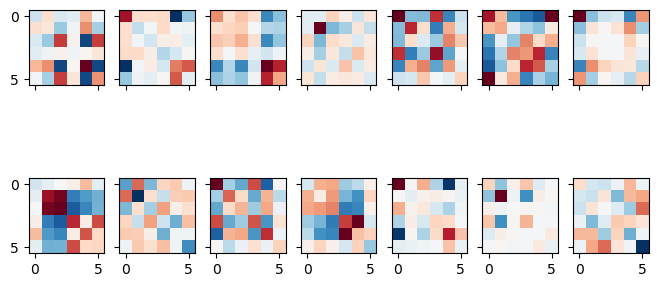

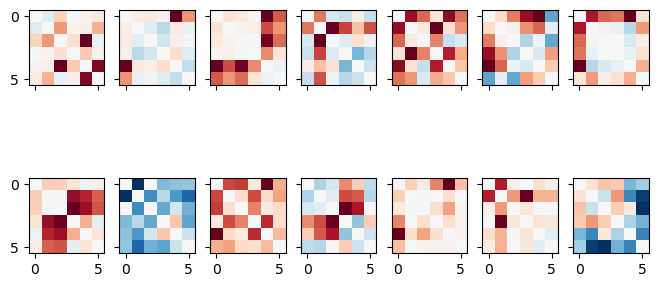

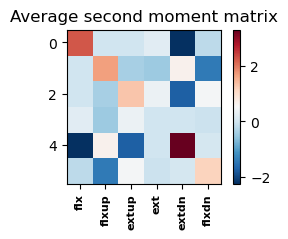

In [19]:
# Estimate and plot the second moment matrices across all data sets
N=len(Y)
ncond = 6
G_hat = np.zeros((N,ncond,ncond))
for i in range(N):
    G_hat[i,:,:],_ = pcm.est_G_crossval(Y[i].measurements,
                            Y[i].obs_descriptors['cond_vec'],
                            Y[i].obs_descriptors['part_vec'],
                            X=pcm.matrix.indicator(Y[i].obs_descriptors['part_vec']))

cmap = 'RdBu_r'
fig, axs = plt.subplots(nrows=2, ncols=7, figsize=(8,4), sharex=True, sharey=True)
# show all second moment matrices
for i in range(N):
    vmin = G_hat[i,:,:].min()
    vmax = G_hat[i,:,:].max()
    vmax = max(abs(vmax), abs(vmin))
    axs[i//7, i%7].imshow(G_hat[i,:,:], vmin=-vmax, vmax=vmax, cmap=cmap)
plt.show()

cmap = 'RdBu_r'
fig, axs = plt.subplots(nrows=2, ncols=7, figsize=(8,4), sharex=True, sharey=True)
# show all second moment matrices
for i in range(N):
    D = pcm.G_to_dist(G_hat[i,:,:])
    vmin = D.min()
    vmax = D.max()
    vmax = max(abs(vmax), abs(vmin))
    axs[i//7, i%7].imshow(D, vmin=-vmax, vmax=vmax, cmap=cmap)
plt.show()


# average second moment matrix:
G_hat_avg = np.mean(G_hat, axis=0)
vmin = G_hat_avg.min()
vmax = G_hat_avg.max()
fig, ax = plt.subplots(figsize=(3,2))
ax.imshow(G_hat_avg, vmin=vmin, vmax=vmax, cmap=cmap)
ax.set_title('Average second moment matrix')
# set xticks:
xlabels = ['flx','flxup','extup','ext','extdn','flxdn']
ax.set_xticks(np.arange(ncond))
ax.set_xticklabels(xlabels, rotation=90, fontsize=8, fontweight='bold')
# show colorbar:
cbar = plt.colorbar(ax.imshow(G_hat_avg, vmin=vmin, vmax=vmax, cmap=cmap), ax=ax)
plt.show()



models

In [95]:
# Make an empty list
M = []
# Null model: no signal exists
M.append(pcm.FixedModel('null',np.zeros(ncond)))

# directions are independently encoded:
M.append(pcm.FixedModel('independent',np.eye(ncond)))

# Free noise ceiling model
# M.append(pcm.FreeModel('ceil',ncond)) # Noise ceiling model 


In [ ]:
# crossvalidated likelihood 
T_cv, theta_cv = pcm.fit_model_group_crossval(Y, M, fit_scale=True)



Fitting group cross model 0


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 36 is different from 6)